<a href="https://colab.research.google.com/github/keisuke6616/Distance-based-classifier-by-data-transformation-for-high-dimension-strongly-spiked-eigenvalue-mode/blob/master/Figure3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt

import time

# Figure3

In [0]:
t1 = time.time()
np.random.seed(42)
fnc = function()
mls= ML_high_sim()

D = [2**s for s in range(5, 11)]
index = [i for i in range(len(D))]
K = 2

ite = 1000
result = np.zeros((len(D), K, 2))


for d, pc in zip(D, index):
    print('Dimension : {}'.format(d))
    
    n1 = int(np.ceil(d**(2/5)))
    n2 = 2 * n1
    N = [n1, n2]
    
    mu1 = np.zeros(d)
    mu2 = np.array([0 for i in range(d - int(np.ceil(np.sqrt(d))))] + [1 for i in range(int(np.ceil(np.sqrt(d))))])
    mu = [mu1, mu2]
    
    Sigma1 = np.diag([d**(2/3), d**(1/2)] + [1 for i in range(d-2)])    
    Sigma2 = 2 * Sigma1
    Sigma = [Sigma1, Sigma2]
    value, vec, Gamma = [0]*2, [0]*2, [0]*2
    for i in range(2):
        value[i], vec[i] = fnc.eig_sort(Sigma[i])
        Gamma[i] = np.sqrt(value[i]).reshape(-1, d) * vec[i]
    
    for l in range(ite):
        train, test = [0]*2, [0]*2
        for i in range(2):
            Z = np.random.normal(0, 1, (N[i], d))
            train[i] = np.dot(Z, Gamma[i].T) + mu[i]
            
            z = np.random.normal(0, 1, d)
            test[i] = np.dot(z, Gamma[i].T) + mu[i]
            
        # Learn
        ml.NRM_learn(train[0], train[1], [2, 2])
        
        for i in range(2):
            classifier1 = ml.DBDA(test[i])
            classifier2 = ml.T_DBDA(test[i])
            classifier = [classifier1, classifier2]
            for k in range(2):
                if (-1)**i * classifier[k] < 0:
                    result[pc, k, i] += 1

    print('DBDA : {}'.format(result[pc, 0]))
    print('T_DBDA : {}'.format(result[pc, 1]))
    print('')
    

t2 = time.time()
print('Calculation time : {}'.format(t2 - t1))

Dimension : 32
DBDA : [640. 615.]
T_DBDA : [683. 551.]

Dimension : 64
DBDA : [685. 627.]
T_DBDA : [720. 596.]

Dimension : 128
DBDA : [686. 606.]
T_DBDA : [757. 597.]

Dimension : 256
DBDA : [687. 654.]
T_DBDA : [740. 658.]

Dimension : 512
DBDA : [690. 673.]
T_DBDA : [792. 681.]

Dimension : 1024
DBDA : [723. 662.]
T_DBDA : [829. 738.]

Calculation time : 243.48672723770142


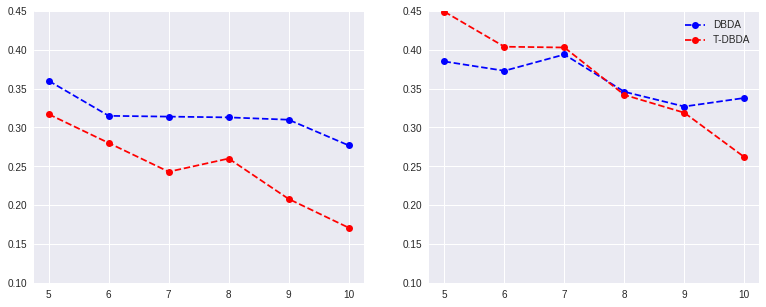

In [0]:
error = np.ones((len(D), K, 2)) - result / ite
log2_D = np.log2(D)

plt.figure(figsize=(13, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(log2_D, error[:, 0, i], 'o--', color='blue', label='DBDA')
    plt.plot(log2_D, error[:, 1, i], 'o--', color='red', label='T-DBDA')
    plt.ylim(0.1, 0.45)
    
plt.legend()

# Function

In [0]:
import numpy as np
import numpy.linalg as la
from scipy.stats import norm


class function:
    
    
################################ prepare ########################################################
    
            
    def eig_sort(self, S):
        value, vec = la.eig(S)
        idx = value.argsort()[::-1]
        P = value[idx]
        Q = vec.T[idx]

        return (P, Q.T)
    
    
    
    def  svd_sort(self, S):
        vec_r, value, vec_l = la.svd(S)
        idx = value.argsort()[::-1]
        P = value[idx]
        Q_r = vec_r.T[idx]
        Q_l = vec_l.T[idx]
        
        return (Q_r.T, P, Q_l.T)
 


    def data(self, X, bias=False):
        self.bias = bias
        self.N, self.D = X.shape
        self.X = X
        self.mean = np.zeros(self.N)
        if bias == False:
            self.mean = np.array([np.mean(self.X, axis=0)]*self.N)
            self.S = np.dot(self.X - self.mean, (self.X - self.mean).T) / (self.N - 1)
            self.value, self.vec = self.eig_sort(self.S)
        
        elif bias == True:
            self.S = np.dot(self.X, self.X.T) / self.N
            self.value, self.vec = self.eig_sort(self.S)
    
        
    def Cov(self):
        return self.S
    
    def Mean(self):
        return self.mean
    
    
    def sign_ad(self, Z): 
        X = Z.T[:self.N+1]
        Y = self.vec.T[:self.N+1]
        for i in range(self.N):
            sign = np.dot(X[i], Y[i])
            if sign < 0:
                Y[i] = - Y[i]

        return Y.T
    
    
    
    def P(self):
        one = np.array([1 for i in range(self.N)])
        mat = np.eye(self.N) - np.einsum('i, j -> ij', one, one) / self.N
        return mat
    
    
    
###################### check SSE Model ###############################
   
    def check_sse(self):
        value = self.CDM_value()
        SDcross = self.SDcross
        phi, tau = [0]*self.n2, [0]*self.n2
        mhat = self.n2 - 2
        
        def kappa(n):
            return np.sqrt(1 / n * np.log(n))
    
        for j in range(self.n2):
            if j == 0:
                phi[j] = np.trace(np.dot(SDcross, SDcross.T))
            else:
                phi[j] = np.trace(np.dot(SDcross, SDcross.T)) - np.sum(value[i]**2 for i in range(j))
        
        for j in range(self.n2 - 1):
            tau[j] = phi[j + 1] / phi[j]
        
        for j in range(self.n2 - 1):
            crit = tau[j] * (1 + (j + 1) * kappa(self.N))
            if crit > 1:
                mhat = j 
                break

                
        mhat = np.min([mhat, self.n2 - 2])
        
        return mhat
    
    
    
######################## estimation of eigen vector ########################
    
    def et_vec(self, value, M):
        vec = np.zeros((self.D, M))    
        
        if self.bias == False:
            for m in range(M):
                vec.T[m] = np.dot(self.vec.T[m], self.X - self.mean) / np.sqrt((self.N - 1) * value[m])
                
        if self.bias == True:
            for m in range(M):
                vec.T[m] = np.dot(self.vec.T[m], self.X) / np.sqrt(self.N * value[m])
                
        return vec  
    
    
    
    def et_vec_self(self, value, M):
        vec = np.zeros((M, self.N, self.D))  
        
        if self.bias == False:
            c = np.sqrt(self.N - 1) / (self.N - 2)
            for m in range(M):
                u_hat = self.vec.T[m]
                for n in range(self.N):
                    u_hat[n] = - u_hat[n] / (self.N - 1)
                    vec[m, n] = c / np.sqrt(value[m]) * np.dot(u_hat, self.X - self.mean)

        if self.bias == True:
            c = np.sqrt(self.N) / (self.N - 1)
            for m in range(M):
                u_hat = self.vec.T[m]
                for n in range(self.N):
                    u_hat[n] = -u_hat[n] / self.N
                    vec[m, n] = c / np.sqrt(value[m]) * np.dot(u_hat, self.X)
                    
        return vec
    
    
################################ projection matrix #########################################

    def prj(self, vec, M):
        prj = np.eye(self.D) - np.sum(np.einsum('i, j -> ij', vec.T[i], vec.T[i]) for i in range(M))
        return prj


    
######################################### dual covariance matrix #######################################
    def dual(self):
        return (self.value, self.vec)
    
    def dual_value(self):
        return self.value

    
    
########################################### noise-reduction ##############################################
    
    def NRM_value(self): 
        value = np.zeros(self.N)
        
        if self.bias == False:
            for j in range(self.N - 2):
                value[j] = self.value[j] - (np.trace(self.S) - np.sum(self.value[0 :(j+1)])) / (self.N - j - 2)
        
        elif self.bias == True:
            for j in range(self.N - 1):
                value[j] = self.value[j] - (np.trace(self.S) - np.sum(self.value[0 :(j+1)])) / (self.N - j - 1)
            
        return value
    
    
    
    def NRM(self): 
        M = self.check_sse()
        value = self.NRM_value()
        spiked_vec = np.zeros((self.D, self.n2))
        spiked_vec_self = np.zeros((self.n2, self.N, self.D))
        
        
        if M != 0:
            spiked_vec = self.et_vec(value, M)
            spiked_vec_self = self.et_vec_self(value, M)

        return (value, spiked_vec, spiked_vec_self, M)
    
    
   
               
        
####################################### cross-data-methodology #############################################
        
    
    def CDM_value(self):
        n1 = int(np.ceil(self.N / 2))
        n2 = self.N - n1
        self.n2 = n2
        X1, X2 = self.X[:n1], self.X[-n2:]
        
        if self.bias == False:    
            mean1 = np.array([np.mean(X1, axis=0)] * n1)
            mean2 = np.array([np.mean(X2, axis=0)] * n2)
            
            self.SDcross = np.dot(X1 - mean1, (X2 - mean2).T) / np.sqrt((n1 - 1) * (n2 - 1))
            value = self.svd_sort(self.SDcross)[1]
            
        if self.bias == True:
            self.SDcross = np.dot(X1, X2.T) / np.sqrt(n1 * n2)
            value = self.svd_sort(self.SDcross)[1]
            
        return value
    
    
    
    
    def CDM(self):
        M = self.check_sse()
        value = self.CDM_value()
        spiked_vec = np.zeros((self.D, self.n2))
        spiked_vec_self = np.zeros((self.n2, self.N, self.D))
        
        
        if M != 0:
            spiked_vec = self.et_vec(value, M)
            spiked_vec_self = self.et_vec_self(value, M)

        return (value, spiked_vec, spiked_vec_self, M)
    
    
    

############################### estiomation of tr(Sigma^2) #################################
    
        
    def ECDM_data(self, X):
        N, D = X.shape
        n = []
        n.append(int(np.ceil(N / 2)))
        n.append(N - n[0])

        K = [i for i in range(3, 2*N)]
        index =  [i for i in range(len(K))]


        V = [[], []]
        Y = np.zeros((2, len(K), D))
        for k, pc in zip(K, index):
            dv = int(np.floor(k / 2))

            if dv < n[0]:
                V[0].append([i for i in range(dv)] + [i for i in range(dv + n[1], N)])  
            else:
                V[0].append([i for i in range(dv - n[0], dv)])

            if dv <= n[0]:
                V[1].append([i for i in range(dv, dv + n[1])])
            else:
                V[1].append([i for i in range(dv - n[0])] + [i for i in range(dv, N)])

            for i in range(2):
                Y[i, pc] = np.sum(X[V[i][pc]], axis=0) / n[i]

        w = 0
        for j in range(N):
            for i in range(j):
                w += np.dot(X[i] - Y[0][i + j - 1], X[j] - Y[1][i + j - 1]) ** 2

        u =  n[0] * n[1] / ((n[0] - 1) * (n[1] - 1))
        W = 2 * u / (N * (N - 1)) * w

        return W
    
    
    
    def ECDM(self):
        n = []
        n.append(int(np.ceil(self.N / 2)))
        n.append(self.N - n[0])

        K = [i for i in range(3, 2*self.N)]
        index =  [i for i in range(len(K))]


        V = [[], []]
        Y = np.zeros((2, len(K), self.D))
        for k, pc in zip(K, index):
            dv = int(np.floor(k / 2))

            if dv < n[0]:
                V[0].append([i for i in range(dv)] + [i for i in range(dv + n[1], self.N)])  
            else:
                V[0].append([i for i in range(dv - n[0], dv)])

            if dv <= n[0]:
                V[1].append([i for i in range(dv, dv + n[1])])
            else:
                V[1].append([i for i in range(dv - n[0])] + [i for i in range(dv, self.N)])

            for i in range(2):
                Y[i, pc] = np.sum(self.X[V[i][pc]], axis=0) / n[i]

        w = 0
        for j in range(self.N):
            for i in range(j):
                w += np.dot(self.X[i] - Y[0][i + j - 1], self.X[j] - Y[1][i + j - 1]) ** 2

        u =  n[0] * n[1] / ((n[0] - 1) * (n[1] - 1))
        W = 2 * u / (self.N * (self.N - 1)) * w

        return W
    
        
    def W_data(self, X, A):
        N,  D= X.shape

        def nPr(n, r):
            import math
            c = int(math.factorial(n) / math.factorial(n - r))
            return c

        w = [0]*3
        for i in range(N):
            for j in range(N):
                if i != j:
                    w[0] += np.einsum('i, ij, j', X[i], A, X[j])**2

                for s in range(N):
                    if i != j and j!= s and s != i:
                        w[1] += np.einsum('i, ij, j', X[i], A, X[j]) * np.einsum('j, js, s', X[j], A, X[s])

                    for t in range(N):
                        if i != j and i != s and i!= t and j != s and j != t and s != t:
                            w[2] += np.einsum('i, ij, j', X[i], A, X[j]) * np.einsum('s, st, t', X[s], A, X[t])

        W = w[0] / nPr(N, 2) - 2 * w[1] / nPr(N, 3) + w[2] / nPr(N, 4)
        
        return W
    
    def W_data_eye(self, X):
        N,  D= X.shape

        def nPr(n, r):
            import math
            c = int(math.factorial(n) / math.factorial(n - r))
            return c

        w = [0]*3
        for i in range(N):
            for j in range(N):
                if i != j:
                    w[0] += np.dot(X[i], X[j])**2

                for s in range(N):
                    if i != j and j!= s and s != i:
                        w[1] += np.dot(X[i], X[j]) * np.dot(X[j], X[s])

                    for t in range(N):
                        if i != j and i != s and i!= t and j != s and j != t and s != t:
                            w[2] += np.dot(X[i], X[j]) * np.dot(X[s], X[t])

        W = w[0] / nPr(N, 2) - 2 * w[1] / nPr(N, 3) + w[2] / nPr(N, 4)
        
        return W
    
    
############### T_hat #####################################3

    def T_hat(self, X, x):
        N, p = X.shape

        n = []
        n.append(int(np.ceil(N / 2)))
        n.append(N - n[0])

        K = [i for i in range(3, 2*N)]
        index =  [i for i in range(len(K))]


        V = [[], []]
        Y = np.zeros((2, len(K), p))
        y = np.zeros((2, len(K)))
        for k, pc in zip(K, index):
            dv = int(np.floor(k / 2))

            if dv < n[0]:
                V[0].append([i for i in range(dv)] + [i for i in range(dv + n[1], N)])   
            else:
                V[0].append([i for i in range(dv - n[0], dv)])

            if dv <= n[0]:
                V[1].append([i for i in range(dv, dv + n[1])])
            else:
                V[1].append([i for i in range(dv - n[0])] + [i for i in range(dv, N)])

            for i in range(2):
                Y[i, pc] = np.sum(X[V[i][pc]], axis=0) / n[i]
                y[i, pc] = np.sum(x[V[i][pc]]) / n[i]

        w = 0
        for j in range(N):
            for i in range(j):
                w += np.dot(X[i] - Y[0][i + j - 1], X[j] - Y[1][i + j - 1]) * (x[i] - y[0][i + j - 1]) * (x[j] - y[1][i + j - 1])

        u =  n[0] * n[1] / ((n[0] - 1) * (n[1] - 1))
        T = 2 * u / (N * (N - 1)) * w

        return T

# ML_high

In [0]:
import numpy as np
import numpy.linalg as la
from scipy.stats import norm

from sklearn.svm import SVC



class ML_high_sim:
######################## prepare ###################################

    def __init__(self):
        self.fnc = function()
        
######################### NRM #####################################
        
    
    def NRM_learn(self, X1, X2, M, bias=False):
        self.bias = bias
        
        n1, n2 = X1.shape[0], X2.shape[0]
        self.D = X1.shape[1]
        self.N = [n1, n2]
        self.X = [X1, X2]
        
        self.cov, self.trS, self.mean = [0]*2, [0]*2, [0]*2
        self.diag = [0]*2
        self.value, self.vec, self.vec_self = [0]*2, [0]*2, [0]*2
        self.M = M

        for i in range(2):    
            self.fnc.data(self.X[i], bias=self.bias)
            self.mean[i] = np.mean(self.X[i], axis=0)
            self.cov[i] = np.cov(self.X[i], rowvar=False)
            self.trS[i] = np.trace(self.cov[i])
            self.diag[i] = np.diag(self.cov[i])
            
            self.value[i] = self.fnc.NRM_value()
            self.vec[i] = self.fnc.et_vec(self.value[i], M[i])
            self.vec_self[i] = self.fnc.et_vec_self(self.value[i], M[i])


            
######################### CDM ####################################

    def CDM_learn(self, X1, X2, M, bias=False):
        self.bias = bias
        
        n1, n2 = X1.shape[0], X2.shape[0]
        self.D = X1.shape[1]
        self.N = [n1, n2]
        self.X = [X1, X2]
        
        self.cov, self.trS, self.mean = [0]*2, [0]*2, [0]*2
        self.diag = [0]*2
        self.value, self.vec, self.vec_self = [0]*2, [0]*2, [0]*2
        self.M = M

        for i in range(2):    
            self.fnc.data(self.X[i], bias=self.bias)
            self.mean[i] = np.mean(self.X[i], axis=0)
            self.cov[i] = np.cov(self.X[i], rowvar=False)
            self.trS[i] = np.trace(self.cov[i])
            self.diag[i] = np.diag(self.cov[i])
            
            self.value[i] = self.fnc.NRM_value()
            self.vec[i] = self.fnc.et_vec(self.value[i], M[i])
            self.vec_self[i] = self.fnc.et_vec_self(self.value[i], M[i])
    
        
######################### classifier #################################

    def DBDA(self, x):
        classifier = np.dot(x - (self.mean[0] + self.mean[1]) / 2, self.mean[1] - self.mean[0]) - self.trS[0] / (2 * self.N[0]) + self.trS[1] / (2 * self.N[1])
        return classifier
        
    
    def GQDA(self, x):
        classifier = self.D * la.norm(x - self.mean[0])**2 / self.trS[0] - self.D * la.norm(x - self.mean[1])**2 / self.trS[1] \
                    - self.D * np.log(self.trS[1] / self.trS[0]) - self.D / self.N[0] + self.D / self.N[1]
        return classifier
    
    
    def DLDA(self, x):
        S_d_inv = np.diag((((self.N[0] - 1) * self.diag[0] + (self.N[1] - 1) * self.diag[1]) / (self.N[0] + self.N[1] - 2))**(-1))
        classifier = np.einsum('i, ij, j', x - (self.mean[0] + self.mean[1]) / 2, S_d_inv, self.mean[1] - self.mean[0])
        return classifier
    
    
    def DQDA(self, x):
        S_d0_inv = np.diag(self.diag[0]**(-1))
        S_d1_inv = np.diag(self.diag[1]**(-1))
        classifier = np.einsum('i, ij, j', x - self.mean[0], S_d0_inv, x - self.mean[0]) - np.einsum('i, ij, j', x - self.mean[1], S_d1_inv, x - self.mean[1]) \
                                    - np.sum(np.log(self.diag[1])) + np.sum(np.log(self.diag[0]))
        return classifier
    
    
    def HM_LSVM(self, x):
        svm = SVC(C=float('inf'), kernel='linear')
        Y = np.r_[self.X[0], self.X[1]]
        y = [-1] * self.N[0] + [1] * self.N[1]
        svm.fit(Y, y)
        classifier = svm.predict([x])
        return classifier
        
    
    def T_DBDA(self, x):
        
        term1 = np.sum(np.dot(x, self.vec[0].T[r]) * (np.sum(np.dot(self.X[0][j], self.vec_self[0][r, j]) / self.N[0] for j in range(self.N[0])) 
                       - 1 / 2 * np.dot(self.vec[0].T[r], self.mean[1] - np.sum(np.sum(np.dot(self.X[1][j], self.vec_self[1][s, j]) / self.N[1] for j in range(self.N[1])) \
                                                                                * self.vec[1].T[s] for s in range(self.M[1])))) for r in range(self.M[0]))
        
        term2 = np.sum(np.dot(x, self.vec[1].T[r])  * (np.sum(np.dot(self.X[1][j], self.vec_self[1][r, j]) / self.N[1] for j in range(self.N[1])) \
                       - 1 / 2 * np.dot(self.vec[1].T[r], self.mean[0] - np.sum(np.sum(np.dot(self.X[0][j], self.vec_self[0][s, j]) / self.N[0] for j in range(self.N[0])) \
                                                                                * self.vec[0].T[s] for s in range(self.M[0])))) for r in range(self.M[1]))
        
        term3 = np.sum(np.sum(np.sum(np.dot(self.X[0][i], self.vec_self[0][r, i]) * np.dot(self.X[0][j], self.vec_self[0][r, j]) for i in range(j)) for j in range(self.N[0])) \
                      / (self.N[0] * (self.N[0] - 1)) for r in range(self.M[0]))
        
        term4 = np.sum(np.sum(np.sum(np.dot(self.X[1][i], self.vec_self[1][r, i]) * np.dot(self.X[1][j], self.vec_self[1][r, j]) for i in range(j)) for j in range(self.N[1])) \
                      / (self.N[1] * (self.N[1] - 1)) for r in range(self.M[1]))

        classifier = self.DBDA(x) + term1 - term2 - term3 + term4
        return classifier
    
    
    
    def BCNN(self, x):
        term1 = np.zeros(self.N[0])
        term2 = np.zeros(self.N[1])
        for j in range(self.N[0]):
            term1[j] = la.norm(x - self.X[0][j])**2 \
                                - np.sum(np.dot(self.X[0][j], self.vec_self[0][r, j]) for r in range(self.M[0]))  \
                                + 2 * np.sum(np.dot(self.X[0][j], self.vec_self[0][r, j]) * np.dot(x, self.vec[0].T[r]) for r in range(self.M[0])) \
                                - np.sum(np.dot(self.X[0][j], self.vec[1].T[s]) * np.dot(x, self.vec[1].T[s]) for s in range(self.M[1])) \
                                - np.sum(np.sum(np.dot(self.vec[0].T[r], self.vec[1].T[s]) * np.dot(self.X[0][j], self.vec_self[0][r, j]) * np.dot(x, self.vec[1].T[s]) for r in range(self.M[0])) for s in range(self.M[1]))

        for j in range(self.N[1]):
            term2[j] = la.norm(x - self.X[1][j])**2 \
                                - np.sum(np.dot(self.X[1][j], self.vec_self[1][s, j]) for s in range(self.M[1]))  \
                                + 2 * np.sum(np.dot(self.X[1][j], self.vec_self[1][s, j]) * np.dot(x, self.vec[1].T[s]) for s in range(self.M[1])) \
                                - np.sum(np.dot(self.X[1][j], self.vec[0].T[r]) * np.dot(x, self.vec[0].T[r]) for r in range(self.M[0])) \
                                - np.sum(np.sum(np.dot(self.vec[0].T[r], self.vec[1].T[s]) * np.dot(self.X[1][j], self.vec_self[1][s, j]) * np.dot(x, self.vec[0].T[r]) for r in range(self.M[0])) for s in range(self.M[1]))

        classifier = np.min(term1) - np.min(term2) - self.trS[0] + self.trS[1]  \
                    + np.sum(self.value[0][r] for r in range(self.M[0])) - np.sum(self.value[1][s] for s in range(self.M[1]))

        return classifier


